<a href="https://colab.research.google.com/github/Brunapupo/finetuning-llama3-lora/blob/main/LLM_stt_chat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Fine-Tuning Llama 3**

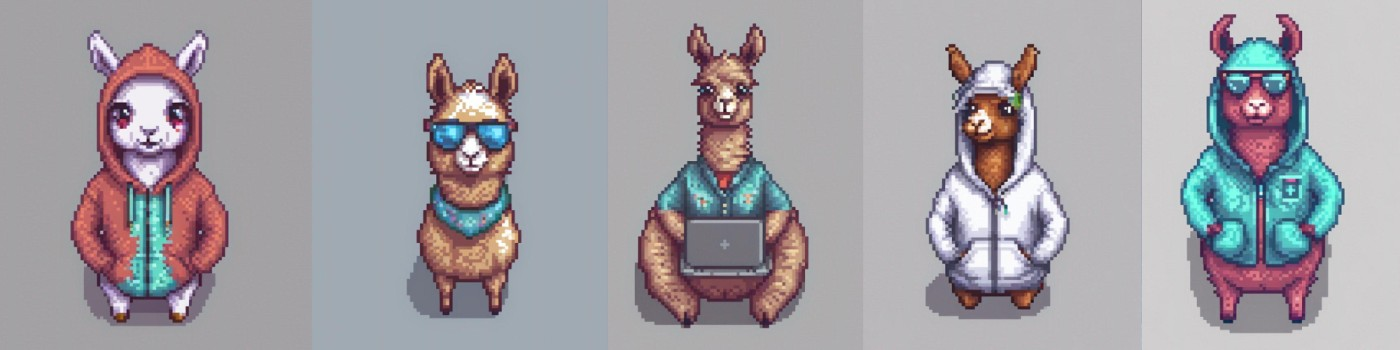


# **1. Instalando as bibliotecas necessárias.**

In [ ]:
!pip install --upgrade torchvision torchaudio
!pip install torch --upgrade
!pip install transformers[torch] --upgrade
!pip install accelerate -U

In [ ]:
%%capture
!pip install accelerate
!pip install peft
!pip install bitsandbytes
!pip install transformers
!pip install transformers huggingface_hub
!pip install trl

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer
import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
import torch
print(torch.cuda.is_available())


# **2. Autenticando-se no Hugging Face Hub**

In [ ]:
from huggingface_hub import notebook_login, logout

notebook_login()

# **Para acessar o modelo Llama2**

 - Você pode acessar o modelo Llama-2 oficial do Meta em Hugging Face, mas é necessário solicitar uma solicitação e aguardar alguns dias para obter a confirmação. Em vez de esperar, usaremos o Llama-2-7b-chat-hf da NousResearch como nosso modelo base. É igual ao original, mas de fácil acesso.



---




# **3. Fine-Tuning do Modelo "Llama-2-7b-chat-hf" com Dataset Personalizado**

Neste experimento, realizei o fine-tuning do modelo base "Llama-2-7b-chat-hf" utilizando um dataset personalizado, composto por informações de manuais técnicos de orientação para usuários, especificamente do manual de teledermatologia do STT. O dataset, denominado "Brunapupo/teledermato-data", foi construído utilizando "corpus dourado", onde a coleta e a organização dos dados foram feitas manualmente para garantir coerência e qualidade. Isso resulta em um dataset robusto e confiável para o treinamento do modelo.

---



- dataset: https://huggingface.co/datasets/Brunapupo/teledermato-data

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import pandas as pd

token = ["Token"]

model_name = "meta-llama/Meta-Llama-3-8B"
telemed_dataset = "Brunapupo/teledermato-data"
new_model = "llama-3-8B-chat-teledemarto-model"


tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AutoModelForCausalLM.from_pretrained(model_name, token=token)

dataset = load_dataset(telemed_dataset, split="train")


df = pd.DataFrame(dataset)
print(df.head(26))

# **4. Carregando o Dataset "teledermato-data" com Transformers com a Função load_dataset que Faz a Leitura e Preparação dos Dados para Treinamento.**

---



In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

dataset = load_dataset(telemed_dataset,  split="train")

## **Configuração de Quantização de 4 Bits com QLoRA**

A quantização de 4 bits via QLoRA (Quantized Low-Rank Adaptation) permite o fine-tuning eficiente de grandes modelos LLM em hardware de consumo, mantendo alto desempenho. Isso melhora drasticamente a acessibilidade e a usabilidade para aplicativos do mundo real.

QLoRA quantiza um modelo de linguagem pré-treinado em 4 bits e congela os parâmetros. Um pequeno número de camadas adaptadoras de baixo nível treináveis é então adicionado ao modelo.

Durante o ajuste fino, os gradientes são retropropagados através do modelo quantizado congelado de 4 bits apenas nas camadas do adaptador de classificação baixa. Assim, todo o modelo pré-treinado permanece fixo em 4 bits enquanto apenas os adaptadores são atualizados. Além disso, a quantização de 4 bits não prejudica o desempenho do modelo.


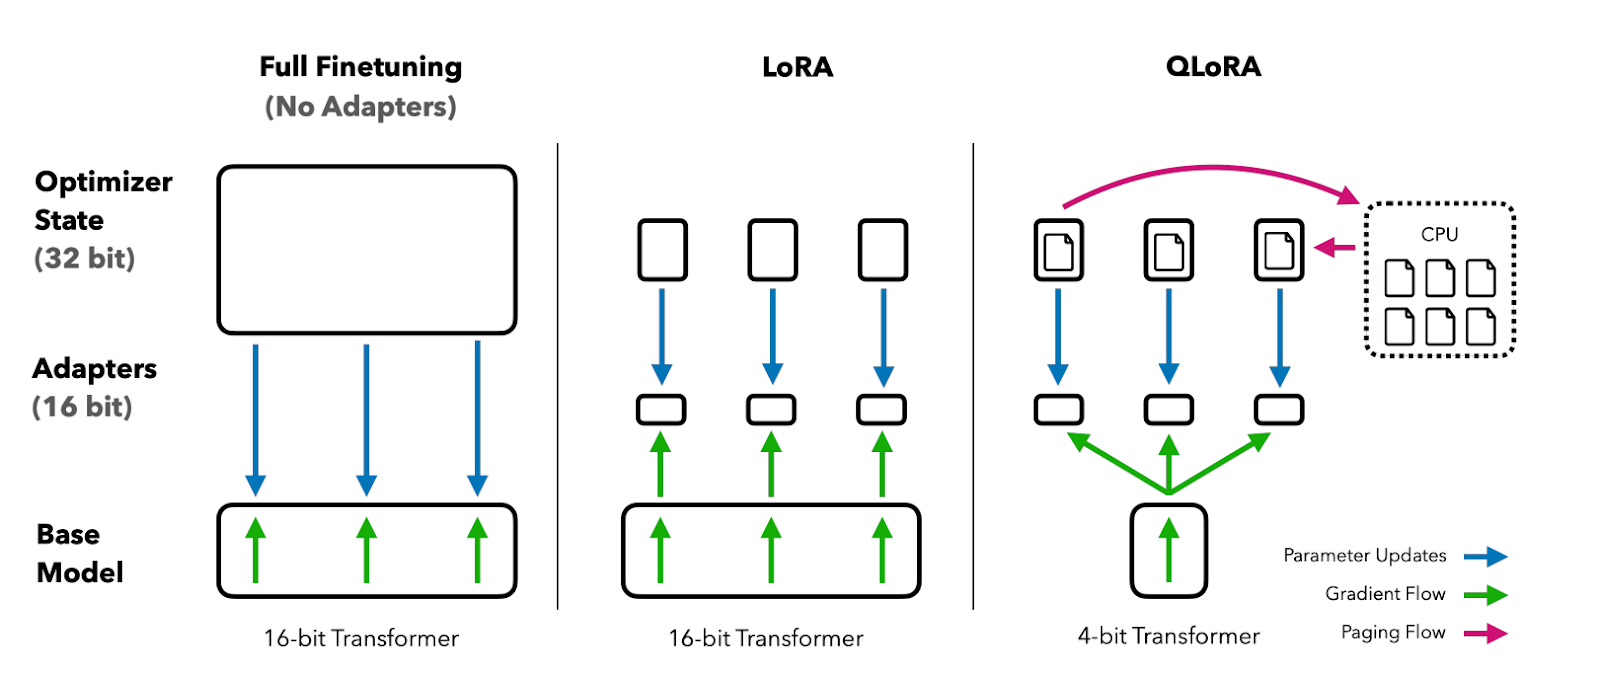



Artigo sobre QLora: Efficient Finetuning of Quantized LLMs: https://arxiv.org/abs/2305.14314









# **Configurando Quantização de 4 Bits com BitsAndBytes para Melhorar a Eficiência Computacional**


Configuração de quantização de 4 bits usando a biblioteca BitsAndBytes para melhorar a eficiência computacional do modelo. A quantização reduz a quantidade de memória necessária para armazenar os pesos do modelo, permitindo que modelos grandes sejam executados em hardware com menos recursos.

O float16 é um formato numérico de 16 bits usado para melhorar a eficiência na computação de modelos de aprendizado de máquina. Ele ocupa metade da memória do float32, permitindo carregar modelos maiores em GPUs limitadas. Além disso, operações em float16 são mais rápidas e consomem menos energia, acelerando o treinamento e a inferência.

*   compute_dtype: Define o tipo de dado para a computação, neste caso float16.
*   load_in_4bit: Habilita a quantização de 4 bits.
*   bnb_4bit_quant_type: Define o tipo de quantização como nf4.
*   bnb_4bit_compute_dtype: Define o tipo de dado usado para a computação, configurado como float16.
*   bnb_4bit_use_double_quant: Define se a quantização dupla será utilizada, neste caso está desativada.


Essa configuração é útil para ajustar o modelo de linguagem com maior eficiência, utilizando menos memória sem comprometer significativamente o desempenho.



---


# **5. Código de Configuração de Quantização de 4 Bits (QLoRA)**

Inicialmente, foi utilizada a técnica QLoRA (Quantized Low-Rank Adaptation) para otimizar o fine-tuning de grandes modelos de linguagem. A quantização de 4 bits, parte do QLoRA, reduz a memória necessária para armazenar os pesos do modelo.

- Para configurar a quantização e LoRA, foram definidos os parâmetros de quantização de 4 bits e os parâmetros da LoRA. Primeiro, é preciso configurar a quantização de 4 bits usando a biblioteca BitsAndBytes para reduzir a quantidade de memória necessária.

In [ ]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)


# **6. Carregando o modelo Llama 2**

 Carrega e configura um modelo de linguagem utilizando quantização de 4 bits e tipo de dado de computação float16 para um treinamento mais rápido e eficiente, aproveitando a infraestrutura da Hugging Face.

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name, #carrega o modelo
    quantization_config=quant_config, # Configuração de quantização para usar 4 bits
    device_map={"": 0}  # Mapeia o modelo para o dispositivo 0 (geralmente a GPU)
)

# Desativa o uso de cache durante a geração de texto
model.config.use_cache = False

# Define um parâmetro específico relacionado ao pré-treinamento do modelo
model.config.pretraining_tp = 1


# **Loading tokenizer**
**Basicamente, nesta parte, é realizado a combinação da técnica do QLoRA com quantização de 4 bits para realizar o fine-tuning com a técnica LoRA, que adiciona matrizes de baixa classificação ao modelo sem a parte de quantização, para reduzir a quantidade de memória e o tempo necessários para ajustar o modelo, mantendo a precisão do modelo original.**

- O tokenizador converte texto em tokens numéricos.
- Define o token de preenchimento como o token de fim de sequência (eos_token).
- Configura o preenchimento para o lado direito para compatibilidade com fp16.



# **7. Carregar o Tokenizador:**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)  #Converte o texto em tokes, que são representações númericas.
tokenizer.pad_token = tokenizer.eos_token # O token de preenchimento garante que todas as sequências tenham o mesmo comprimento
tokenizer.padding_side = "right"

# **8. Configura a Quantização e LoRA:**

- Para configurar a quantização e LoRA, é necessário definir os parâmetros de quantização de 4 bits e os parâmetros da LoRA.

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

# **QLoRA X LoRa**

Neste processo, foi utilizada a técnica **QLoRA (Quantized Low-Rank Adaptation) para otimizar o fine-tuning de grandes modelos de linguagem.** A quantização de 4 bits, parte do QLoRA, reduz a memória necessária para armazenar os pesos do modelo, enquanto a LoRA permite um fine-tuning eficiente, mantendo a precisão do modelo original.

A diferença entre LoRA e QLoRA é que QLoRA incorpora a quantização de 4 bits para maior eficiência, **enquanto LoRA apenas adiciona matrizes de baixa classificação ao modelo sem a parte de quantização.** Utilizei ambos para aproveitar os benefícios de cada técnica, garantindo um ajuste fino eficiente e eficaz.









# **Trainer**

# **9. Parâmetros de treinamento**

Abaixo está uma lista de hiperparâmetros que podem ser usados ​​para otimizar o processo de treinamento:

- output_dir: Define o diretório onde os resultados e os checkpoints serão salvos.
- num_train_epochs: Número de épocas (passes completos pelo conjunto de treinamento) a serem realizadas durante o treinamento.
- per_device_train_batch_size: Tamanho do lote (batch) de treinamento por dispositivo (GPU/CPU).
- gradient_accumulation_steps: Número de passos de acumulação de gradientes antes de atualizar os pesos do modelo.
- optim: Otimizador a ser usado durante o treinamento. No exemplo, "paged_adamw_32bit" é um otimizador específico.
- save_steps: Número de passos de treinamento entre cada salvamento de checkpoint.
- logging_steps: Número de passos de treinamento entre cada registro de logs.
- learning_rate: Taxa de aprendizado a ser usada pelo otimizador.
- weight_decay: Fator de decaimento de peso a ser usado para regularização L2.
- fp16: Booleano indicando se deve ser usada a precisão mista com ponto flutuante de 16 bits (Half Precision).
- bf16: Booleano indicando se deve ser usada a precisão mista com ponto flutuante de 16 bits (Brain Floating Point).
- max_grad_norm: Valor máximo para normalização de gradiente (clipping) para evitar gradientes explosivos.
- max_steps: Número total de passos de treinamento a serem realizados. Se for -1, ignora esse parâmetro.
- warmup_ratio: Proporção do total de passos de treinamento para realizar warm-up (aumento gradual da taxa de aprendizado).
- group_by_length: Booleano indicando se deve agrupar os exemplos de treinamento por comprimento para otimizar a eficiência de processamento.
- lr_scheduler_type: Tipo de agendador de taxa de aprendizado a ser usado. No exemplo, "constant" mantém a taxa de aprendizado constante.
- report_to: Plataforma para onde os logs serão enviados. No exemplo, "tensorboard" é usado para visualização de logs.


In [ ]:
training_params = TrainingArguments(
    output_dir=new_model,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=1,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-4,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="wandb"
)


# **10. Fine-tuning do modelo**

- O ajuste fino supervisionado (SFT) é uma etapa fundamental na aprendizagem por reforço a partir do feedback humano (RLHF). A biblioteca TRL do HuggingFace fornece uma API fácil de usar para criar modelos SFT e treiná-los em seu conjunto de dados com apenas algumas linhas de código. Ele vem com ferramentas para treinar modelos de linguagem usando aprendizagem por reforço, começando com ajuste fino supervisionado, depois modelagem de recompensa e, finalmente, otimização de política proximal (PPO).



# **Forneceremos ao SFT Trainer o modelo, conjunto de dados, configuração do Lora, tokenizer e parâmetros de treinamento:**

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
!pip install tensorboard
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="text",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)


In [ ]:
from huggingface_hub import notebook_login, logout

notebook_login()

# **11. Foi utilizado .train() para fine-tune do modelo Llama2 em um novo conjunto de dados.**

In [ ]:
trainer.train()

# **Após treinar o modelo, é possivel salvar os tokenizadores do modelo.Também é possivel fazer upload do modelo para Hugging Face usando uma API.**

In [ ]:
trainer.model.save_pretrained(new_model)
trainer.tokenizer.save_pretrained(new_model)

from huggingface_hub import notebook_login, logout

notebook_login()

In [ ]:
trainer.model.save_pretrained(new_model)
trainer.model.push_to_hub(new_model, use_temp_dir=False)

# **Prompt 1**

In [ ]:
logging.set_verbosity(logging.CRITICAL)


prompt = "Como posso realizar o cadastewd no siatwm?"

pipe = pipeline(
    task="text-generation",  # Especifica a tarefa como geração de texto
    model=model,             # O modelo de linguagem que será utilizado
    tokenizer=tokenizer,     # O tokenizador que converte texto em tokens numéricos
    max_length=400,          # Comprimento máximo da sequência gerada
    num_return_sequences=1,  # Número de sequências de resposta a serem geradas
    do_sample=True,          # Ativa a amostragem para gerar respostas variadas
    top_k=50,                # Considera os top 50 tokens com maior probabilidade na geração
    top_p=0.95               # Usa nucleação de probabilidade (top-p) para maior variabilidade e coerência
)

result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

generated_text = result[0]['generated_text']
for line in generated_text.split('. '):
    print(line.strip() + '.')

# **Prompt 2**

In [ ]:
# Define o nível de verbosidade para CRITICAL
logging.set_verbosity(logging.CRITICAL)

prompt = "Qual é o objetivo da teledermatologia?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, repetition_penalty=1.2)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

# **Prompt 3**

In [ ]:
# Define o nível de verbosidade para CRITICAL
logging.set_verbosity(logging.CRITICAL)

prompt = "O que fazer se encontrar dificuldade com um exame específico?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, repetition_penalty=1.2)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
# Define o nível de verbosidade para CRITICAL
logging.set_verbosity(logging.CRITICAL)

prompt = "quem é a monalisa?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, repetition_penalty=1.2)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

# **Prompt 4**

In [ ]:
# Define o nível de verbosidade para CRITICAL
logging.set_verbosity(logging.CRITICAL)

prompt = "Qual é o objetivo da teledermatologia?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, repetition_penalty=1.2)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

# **Prompt 5**

In [ ]:
# Define o nível de verbosidade para CRITICAL
logging.set_verbosity(logging.CRITICAL)

prompt = "Quais são os requisitos de imagem para o registro fotográfico em casos de câncer de pele?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, repetition_penalty=1.2)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

# **Prompt 5 sem emojis**

In [ ]:
# Define o nível de verbosidade para CRITICAL
logging.set_verbosity(logging.CRITICAL)

prompt = "<s>[INST] <<SYS>>Por favor, forneça uma resposta detalhada sem usar emojis.<</SYS>>\nQuais são os requisitos de imagem para o registro fotográfico em casos de câncer de pele?[/INST]"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, repetition_penalty=1.2)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

# **Prompt 6**

In [ ]:
logging.set_verbosity(logging.CRITICAL)

prompt = "O que é uma dermatologia no STT?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, repetition_penalty=1.2)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
!python llama.cpp/convert-hf-to-gguf.py /home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model --outfile /home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model.gguf


In [ ]:
!git clone https://github.com/ggerganov/llama.cpp.git


In [ ]:
!ls llama.cpp


In [ ]:
!python llama.cpp/convert_hf_to_gguf.py /home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model --outfile /home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model.gguf


In [ ]:
!ls /home/jovyan/compartilhado/llms-stt/bruna/llama.cpp



In [ ]:
!pip install sentencepiece


In [ ]:
!python /home/jovyan/compartilhado/llms-stt/bruna/llama.cpp/convert_hf_to_gguf.py /home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model --outfile /home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model.gguf


In [ ]:
!cat /home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model/config.json


In [ ]:
ls -lh /home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model.gguf



In [ ]:
trainer.model.save_pretrained("/home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model/")


In [ ]:
%%capture
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

In [ ]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

hf_token = user_secrets.get_secret("Token")
login(token = hf_token)

In [ ]:
!pip install -U huggingface_hub

from huggingface_hub import login

hf_token = "Token"
login(token=hf_token)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel
import torch
from trl import setup_chat_format

base_model = "meta-llama/Meta-Llama-3-8B"
new_model = "/home/jovyan/compartilhado/llms-stt/bruna/llama-3-8B-chat-teledemarto-model"

# Carregua o tokenizador e o modelo base
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Carregua o modelo base
base_model_reload = AutoModelForCausalLM.from_pretrained(
        base_model,
        return_dict=True,
        low_cpu_mem_usage=True,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
)

base_model_reload, tokenizer = setup_chat_format(base_model_reload, tokenizer)
model = PeftModel.from_pretrained(base_model_reload, new_model)
model = model.merge_and_unload()
model.save_pretrained("/home/jovyan/compartilhado/llms-stt/bruna/merged_llama_model")
tokenizer.save_pretrained("/home/jovyan/compartilhado/llms-stt/bruna/merged_llama_model")


In [ ]:
from transformers import pipeline

messages = [{"role": "user", "content": "O que é uma dermatologia no STT?"}]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# Inicializar o pipeline para geração de texto
pipe = pipeline(
    "text-generation",
    model=model,  # O modelo que foi mesclado e salvo
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",  # Usa várias GPUs automaticamente, se disponíveis
)

outputs = pipe(prompt, max_new_tokens=120, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)

# Exibir a resposta gerada pelo modelo
print(outputs[0]["generated_text"])


In [ ]:
# Salvar o modelo mesclado
model.save_pretrained("llama-3-8B-chat-teledemarto-model")

# Salvar o tokenizador
tokenizer.save_pretrained("llama-3-8B-chat-teledemarto-model")


In [ ]:
model.push_to_hub("llama-3-8B-chat-teledemarto-model", use_temp_dir=False)
tokenizer.push_to_hub("llama-3-8B-chat-teledemarto-model", use_temp_dir=False)

In [ ]:
!git clone --depth=1 https://github.com/ggerganov/llama.cpp.git
%cd llama.cpp
!make -j


In [ ]:
!python /home/jovyan/compartilhado/llms-stt/bruna/llama.cpp/convert_hf_to_gguf.py /home/jovyan/compartilhado/llms-stt/bruna/merged_llama_model/ \
    --outfile /home/jovyan/compartilhado/llms-stt/bruna/merged_llama_model.gguf \
    --outtype f16


In [ ]:
!git clone --depth=1 https://github.com/ggerganov/llama.cpp.git


In [ ]:
!apt-get install libcublas-dev



In [ ]:
%cd /kaggle/working/
!./llama.cpp/llama-quantize /kaggle/input/hf-llm-to-gguf/llama-3-8B-chat-teledemarto-model.gguf llama-3-8B-chat-teledemarto-Q4_K_M.gguf Q4_K_M


In [ ]:
from huggingface_hub import login
from huggingface_hub import HfApi

# Autenticação no Hugging Face
hf_token = "Token"
login(token=hf_token)

# Criação do objeto da API
api = HfApi()


api.upload_file(
    path_or_fileobj="/home/jovyan/compartilhado/llms-stt/bruna/merged_llama_model.gguf",
    path_in_repo="merged_llama_model.gguf",
    repo_id="Brunapupo/llama-3-8B-chat-teledemarto-model",
    repo_type="model",
)
